In [2]:
import matplotlib
from tqdm import tqdm

import pandas as pd
import datetime
import io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
datatypes = {'time': 'str',
              'Winterthur': 'float32', 
              'Büdingen': 'float32',
              'Schondorf': 'float32',
              'Herzogenrath': 'float32',
              'Bremen': 'float32',
              'Dresden': 'float32',
              'Lleida': 'float32',
              'Sibiu': 'float32', 
              'Belfort Cedex': 'float32',
              'Wien (SBA)' : 'float32'};


In [3]:
cols = list(datatypes.keys())

chunksize = 5_000_000 # 5 million rows


df_list = [] # list to hold the batch dataframe

for df_chunk in tqdm(pd.read_csv('/content/drive/My Drive/Colab Notebooks/pha.csv', usecols=cols, dtype=datatypes, chunksize=chunksize)):
     
    # Neat trick from https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    # Using parse_dates would be much slower!
    #df_chunk['time'] = df_chunk['time'].str.slice(0, 16)
    df_chunk['time'] = pd.to_datetime(df_chunk['time'],format='%Y-%m-%d %H:%M:%S')
    df_chunk = df_chunk.rename(columns={'Belfort Cedex':'Belfort_Cedex'})
    df_chunk = df_chunk.assign(b=df_chunk.Schondorf.fillna(df_chunk.Schondorf.mean()))
    df_chunk = df_chunk.assign(a=df_chunk.Belfort_Cedex.fillna(df_chunk.Belfort_Cedex.mean()))
    df_chunk = df_chunk.assign(c=df_chunk.Dresden.fillna(df_chunk.Dresden.mean()))
    df_chunk = df_chunk.assign(d=df_chunk.Dresden.fillna(df_chunk.Bremen.mean()))
    df_chunk['phase_diff2'] = (df_chunk['a'] - df_chunk['b'])
    df_chunk['angle2'] = np.sin(np.deg2rad(df_chunk['phase_diff2']))
    df_chunk['phase_diff3'] = (df_chunk['a'] - df_chunk['c'])
    df_chunk['angle3'] = np.sin(np.deg2rad(df_chunk['phase_diff3']))
    df_chunk['phase_diff4'] = (df_chunk['a'] - df_chunk['d'])
    df_chunk['angle4'] = np.sin(np.deg2rad(df_chunk['phase_diff4']))


  

    df_chunk = df_chunk.resample(rule='1h', on ='time').mean()


    
    # Can process each chunk of dataframe here
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk) 
 

7it [00:59,  8.45s/it]


In [4]:

# Merge all dataframes into one dataframe
phasor_df = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

# See what I have loaded
phasor_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9510 entries, 2019-09-01 00:00:00 to 2020-09-30 23:00:00
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Winterthur     4486 non-null   float32
 1   Büdingen       9510 non-null   float32
 2   Schondorf      9486 non-null   float32
 3   Herzogenrath   9407 non-null   float32
 4   Bremen         6449 non-null   float32
 5   Dresden        9494 non-null   float32
 6   Lleida         9510 non-null   float32
 7   Sibiu          9509 non-null   float32
 8   Belfort_Cedex  9447 non-null   float32
 9   Wien (SBA)     7884 non-null   float32
 10  b              9510 non-null   float32
 11  a              9510 non-null   float32
 12  c              9510 non-null   float32
 13  d              9503 non-null   float32
 14  phase_diff2    9510 non-null   float32
 15  angle2         9510 non-null   float32
 16  phase_diff3    9510 non-null   float32
 17  angle3         9

In [ ]:
phasor_df.head(6)

,Winterthur,Büdingen,Schondorf,Herzogenrath,Bremen,Dresden,Lleida,Sibiu,Belfort_Cedex,Wien (SBA),b,a,c,d,phase_diff2,angle2,phase_diff3,angle3,phase_diff4,angle4
time,,,,,,,,,,,,,,,,,,,,
2019-09-01 00:00:00,NaN,186.911942,160.249725,200.708054,NaN,162.677505,194.167221,160.457230,161.190826,NaN,160.249725,161.190826,162.677505,162.677505,0.941111,0.453009,-1.486667,-0.205758,-1.486667,-0.205758
2019-09-01 01:00:00,NaN,178.417770,180.340561,174.862778,NaN,183.339996,174.301117,181.229721,181.341949,NaN,180.340561,181.341949,183.339996,183.339996,1.001389,0.464817,-1.998056,-0.147751,-1.998056,-0.147751
2019-09-01 02:00:00,NaN,173.973892,175.168060,184.452499,NaN,179.063217,186.401672,179.847504,179.712784,NaN,175.168060,179.712784,179.063522,179.063217,4.544722,0.524595,0.649262,-0.068643,0.451685,-0.069754
2019-09-01 03:00:00,NaN,184.156952,186.003052,167.571106,NaN,180.562500,172.854172,181.114166,182.278885,NaN,186.003052,182.278885,180.562500,180.562500,-3.724167,0.491969,1.716389,-0.103690,1.716389,-0.103690
2019-09-01 04:00:00,NaN,186.820557,175.365829,176.595001,NaN,182.256943,165.912781,178.682419,179.575836,NaN,175.365829,179.575836,182.256943,182.256943,4.210000,0.356796,-2.681111,-0.244345,-2.681111,-0.244345
2019-09-01 05:00:00,NaN,179.839722,191.157776,178.389999,NaN,175.863617,179.402496,177.054718,175.735840,NaN,191.157776,175.735840,175.863617,175.863617,-15.421945,0.412239,-0.127778,-0.180626,-0.127778,-0.180626


In [ ]:
phasor_df.tail(6)

,Winterthur,Büdingen,Schondorf,Herzogenrath,Bremen,Dresden,Lleida,Sibiu,Belfort_Cedex,Wien (SBA),b,a,c,d,phase_diff2,angle2,phase_diff3,angle3,phase_diff4,angle4
time,,,,,,,,,,,,,,,,,,,,
2020-09-30 18:00:00,186.345551,177.178894,181.233063,178.871384,175.717224,178.375839,186.598053,176.908051,179.323883,176.765839,181.233063,179.323883,178.375839,178.375839,-1.909167,0.466401,0.948056,-0.145105,0.948056,-0.145105
2020-09-30 19:00:00,173.597504,180.054718,176.361664,176.244171,175.993332,184.930283,173.045837,184.473053,183.498337,181.086395,176.361664,183.498337,184.930283,184.930283,7.136667,0.524738,-1.431944,-0.335575,-1.431944,-0.335575
2020-09-30 20:00:00,173.452499,183.796951,173.506668,172.853058,174.281189,181.933334,173.956665,182.343887,182.480270,184.607224,173.506668,182.480270,181.933334,181.933334,8.973611,0.521241,0.546944,-0.376728,0.546944,-0.376728
2020-09-30 21:00:00,178.853607,177.845551,176.429443,175.940826,176.321671,179.086105,179.085831,181.113617,184.739716,181.043335,176.429443,184.739716,179.086105,179.086105,8.310278,0.577316,5.653611,-0.460265,5.653611,-0.460265
2020-09-30 22:00:00,183.846664,173.061386,179.828339,179.990555,176.293610,179.608063,183.181946,180.677505,181.855560,177.316116,179.828339,181.855560,179.608063,179.608063,2.027222,0.598572,2.247500,-0.462432,2.247500,-0.462432
2020-09-30 23:00:00,180.112015,175.156982,179.835510,181.452072,176.648514,183.595718,180.217834,183.788315,181.492355,177.762711,179.835510,181.492355,183.595718,183.595718,1.656849,0.613792,-2.103362,-0.481368,-2.103362,-0.481368


In [ ]:
phasor_df.shape

(9510, 20)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f27fe243898>,
      dtype=object)

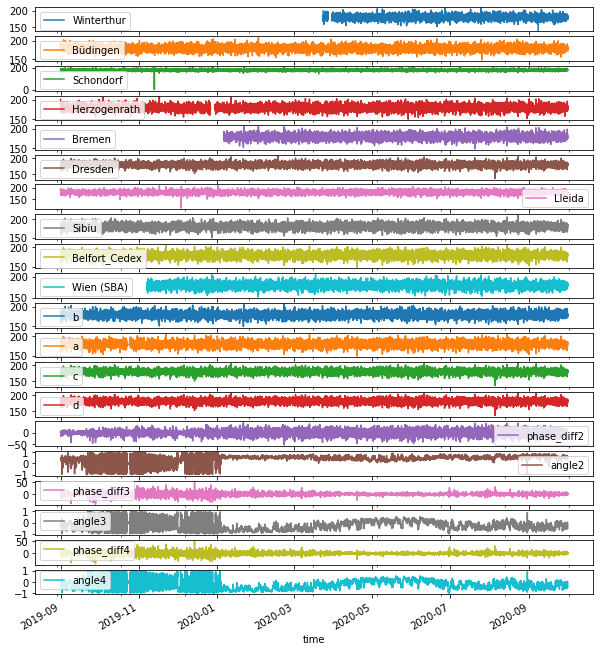

In [ ]:
phasor_df.plot(subplots=True, figsize=(10,12))

In [24]:
import seaborn as sns

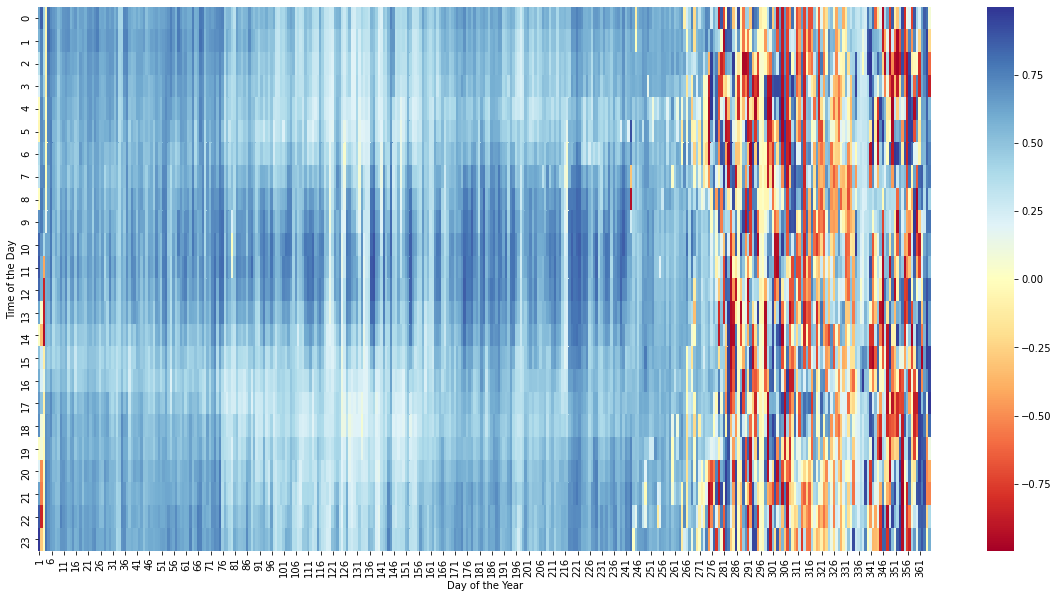

CPU times: user 1.21 s, sys: 162 ms, total: 1.38 s
Wall time: 1.25 s


In [ ]:
%%time
phasor_df_2 = phasor_df.copy()
phasor_df_2['Day'] = [i.dayofyear for i in phasor_df_2.index]
phasor_df_2['hour'] = [i.hour for i in phasor_df_2.index]

# group by month and year, get the average
phasor_df_2 = phasor_df_2.groupby(['Day', 'hour']).mean()

phasor_df_2 = phasor_df_2['angle2'].unstack(level=0)
fig, ax = plt.subplots(figsize=(20, 10))
# cmap = "YlGnBu"
cmap = "RdYlBu"
sns.heatmap(phasor_df_2, cmap=cmap)
plt.xlabel("Day of the Year")
plt.ylabel("Time of the Day")
plt.show()

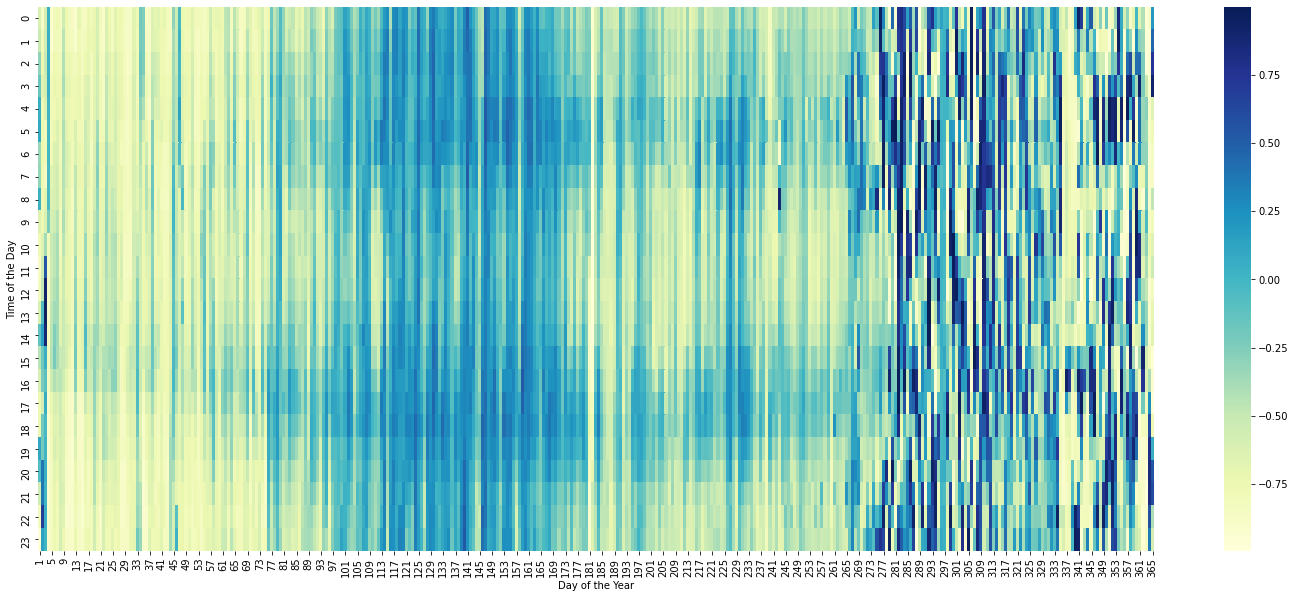

In [ ]:
phasor_df_3 = phasor_df.copy()
phasor_df_3['Day'] = [i.dayofyear for i in phasor_df.index]
phasor_df_3['hour'] = [i.hour for i in phasor_df.index]

# group by month and year, get the average
phasor_df_3 = phasor_df_3.groupby(['Day', 'hour']).mean()

phasor_df_3 = phasor_df_3['angle3'].unstack(level=0)
fig, ax = plt.subplots(figsize=(25, 10))
# cmap = "YlGnBu"
cmap = "YlGnBu"
sns.heatmap(phasor_df_3, cmap=cmap)
plt.xlabel("Day of the Year")
plt.ylabel("Time of the Day")
plt.show()

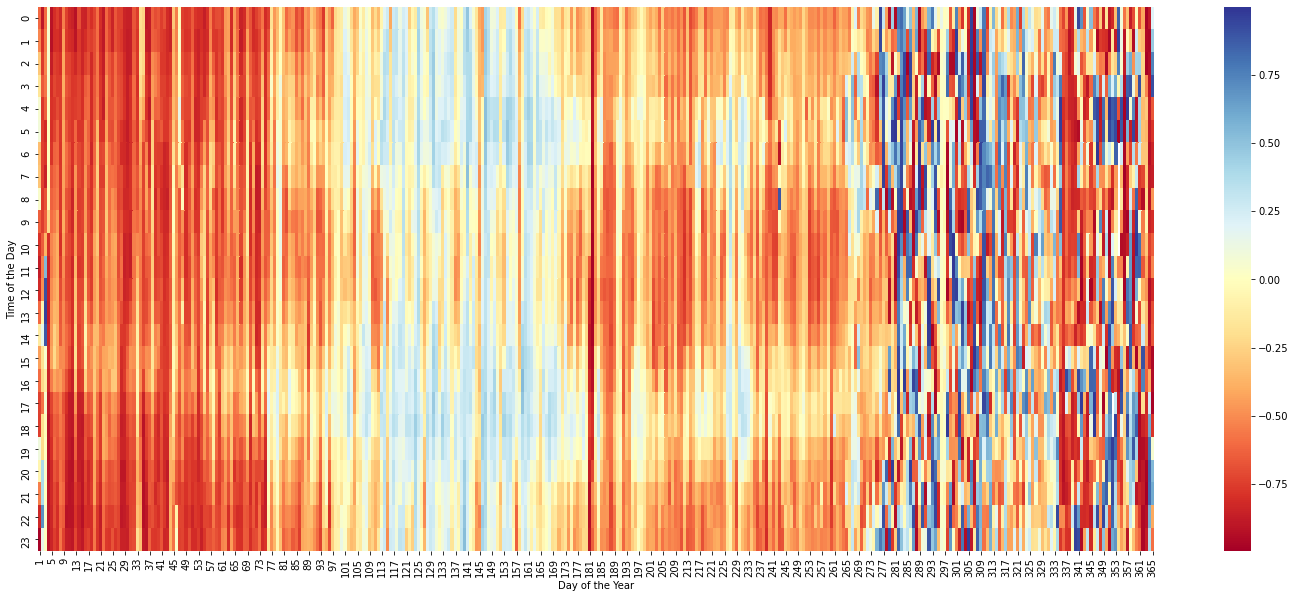

In [ ]:
phasor_df_4 = phasor_df.copy()
phasor_df_4['Day'] = [i.dayofyear for i in phasor_df.index]
phasor_df_4['hour'] = [i.hour for i in phasor_df.index]

# group by month and year, get the average
phasor_df_4 = phasor_df_4.groupby(['Day', 'hour']).mean()

phasor_df_4 = phasor_df_4['angle4'].unstack(level=0)
fig, ax = plt.subplots(figsize=(25, 10))
# cmap = "YlGnBu"
cmap = "RdYlBu"
sns.heatmap(phasor_df_4, cmap=cmap)
plt.xlabel("Day of the Year")
plt.ylabel("Time of the Day")
plt.show()

In [1]:
df = pd.read_csv (r"/content/drive/MyDrive/Cross-Border 2019.csv")

NameError: ignored

In [ ]:
import numpy as np 
import pandas as pd 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df.head()

df.describe()

df['BZN|DE-LU > BZN|FR [MW]-BZN|FR > BZN|DE-LU [MW]'] = df['BZN|DE-LU > BZN|FR [MW]']-df['BZN|FR > BZN|DE-LU [MW]']

df.head()

new_df= df["Time (CET)"].str.split("-",n=1,expand= True)
df["Date part "]=new_df[0]
df["CET_Timestamp"]=new_df[1]


df['CET_Timestamp'] = df['CET_Timestamp'].astype('datetime64[ns]')

df = df.assign(Date= df.CET_Timestamp.dt.date, Time = df.CET_Timestamp.dt.time )
df = df.set_index (['CET_Timestamp'])

df.head(3)

# Add columns with year, month, and weekday name
df['Year'] = df.index.year
df['Month'] = df.index.month
df['day'] = df.index.day
# Display a random sampling of 5 rows
# df.sample(5, random_state=0)

pt_titanic = df.pivot_table(index='Time', columns='Date', values='BZN|DE-LU > BZN|FR [MW]-BZN|FR > BZN|DE-LU [MW]')

plt.figure(figsize=(16,9))
sns.heatmap(pt_titanic,cmap="coolwarm")

pt_titanic2 = df.pivot_table(index='Time', columns='Month', values='BZN|DE-LU > BZN|FR [MW]-BZN|FR > BZN|DE-LU [MW]')

plt.figure(figsize=(16,9))
sns.heatmap(pt_titanic2,cmap="coolwarm")

pt_titanic4 = df.pivot_table(index='Time', columns='day', values='BZN|DE-LU > BZN|FR [MW]-BZN|FR > BZN|DE-LU [MW]')

plt.figure(figsize=(16,9))
sns.heatmap(pt_titanic4,cmap="coolwarm")

pt_titanic6 = df.pivot_table(index='Month', columns='day', values='BZN|DE-LU > BZN|FR [MW]-BZN|FR > BZN|DE-LU [MW]')

plt.figure(figsize=(16,9))
sns.heatmap(pt_titanic6,cmap="coolwarm")

In [6]:
df.head(6)

,Time (CET),BZN|FR > BZN|DE-LU [MW],BZN|DE-LU > BZN|FR [MW]
0,01.01.2019 00:00 - 01.01.2019 01:00,0.0,1044.0
1,01.01.2019 01:00 - 01.01.2019 02:00,0.0,625.0
2,01.01.2019 02:00 - 01.01.2019 03:00,0.0,388.0
3,01.01.2019 03:00 - 01.01.2019 04:00,0.0,176.0
4,01.01.2019 04:00 - 01.01.2019 05:00,0.0,706.0
5,01.01.2019 05:00 - 01.01.2019 06:00,0.0,1088.0


In [7]:
column_means = df.mean()
df = df.fillna(column_means)

In [8]:
df['diff_2'] = (df['BZN|DE-LU > BZN|FR [MW]'] - df['BZN|FR > BZN|DE-LU [MW]'])

In [ ]:
df.head(6)

,Time (CET),BZN|FR > BZN|DE-LU [MW],BZN|DE-LU > BZN|FR [MW],diff_2
0,01.01.2019 00:00 - 01.01.2019 01:00,0.0,1044.0,1044.0
1,01.01.2019 01:00 - 01.01.2019 02:00,0.0,625.0,625.0
2,01.01.2019 02:00 - 01.01.2019 03:00,0.0,388.0,388.0
3,01.01.2019 03:00 - 01.01.2019 04:00,0.0,176.0,176.0
4,01.01.2019 04:00 - 01.01.2019 05:00,0.0,706.0,706.0
5,01.01.2019 05:00 - 01.01.2019 06:00,0.0,1088.0,1088.0


In [9]:
df3= df.append(phasor_df)

In [10]:
df3.head(6)

,Time (CET),BZN|FR > BZN|DE-LU [MW],BZN|DE-LU > BZN|FR [MW],diff_2,Winterthur,Büdingen,Schondorf,Herzogenrath,Bremen,Dresden,Lleida,Sibiu,Belfort_Cedex,Wien (SBA),b,a,c,d,phase_diff2,angle2,phase_diff3,angle3,phase_diff4,angle4
0,01.01.2019 00:00 - 01.01.2019 01:00,0.0,1044.0,1044.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01.01.2019 01:00 - 01.01.2019 02:00,0.0,625.0,625.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01.01.2019 02:00 - 01.01.2019 03:00,0.0,388.0,388.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01.01.2019 03:00 - 01.01.2019 04:00,0.0,176.0,176.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01.01.2019 04:00 - 01.01.2019 05:00,0.0,706.0,706.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,01.01.2019 05:00 - 01.01.2019 06:00,0.0,1088.0,1088.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
column_means = df3.mean()
df3 = df3.fillna(column_means)

In [12]:
df3.head(6)

,Time (CET),BZN|FR > BZN|DE-LU [MW],BZN|DE-LU > BZN|FR [MW],diff_2,Winterthur,Büdingen,Schondorf,Herzogenrath,Bremen,Dresden,Lleida,Sibiu,Belfort_Cedex,Wien (SBA),b,a,c,d,phase_diff2,angle2,phase_diff3,angle3,phase_diff4,angle4
0,01.01.2019 00:00 - 01.01.2019 01:00,0.0,1044.0,1044.0,180.037201,179.3228,179.343506,179.580887,179.334122,179.53447,179.306885,179.391464,179.319626,179.400528,179.365509,179.315613,179.531174,179.531204,-0.050358,0.413487,-0.215977,-0.249458,-0.215408,-0.249628
1,01.01.2019 01:00 - 01.01.2019 02:00,0.0,625.0,625.0,180.037201,179.3228,179.343506,179.580887,179.334122,179.53447,179.306885,179.391464,179.319626,179.400528,179.365509,179.315613,179.531174,179.531204,-0.050358,0.413487,-0.215977,-0.249458,-0.215408,-0.249628
2,01.01.2019 02:00 - 01.01.2019 03:00,0.0,388.0,388.0,180.037201,179.3228,179.343506,179.580887,179.334122,179.53447,179.306885,179.391464,179.319626,179.400528,179.365509,179.315613,179.531174,179.531204,-0.050358,0.413487,-0.215977,-0.249458,-0.215408,-0.249628
3,01.01.2019 03:00 - 01.01.2019 04:00,0.0,176.0,176.0,180.037201,179.3228,179.343506,179.580887,179.334122,179.53447,179.306885,179.391464,179.319626,179.400528,179.365509,179.315613,179.531174,179.531204,-0.050358,0.413487,-0.215977,-0.249458,-0.215408,-0.249628
4,01.01.2019 04:00 - 01.01.2019 05:00,0.0,706.0,706.0,180.037201,179.3228,179.343506,179.580887,179.334122,179.53447,179.306885,179.391464,179.319626,179.400528,179.365509,179.315613,179.531174,179.531204,-0.050358,0.413487,-0.215977,-0.249458,-0.215408,-0.249628
5,01.01.2019 05:00 - 01.01.2019 06:00,0.0,1088.0,1088.0,180.037201,179.3228,179.343506,179.580887,179.334122,179.53447,179.306885,179.391464,179.319626,179.400528,179.365509,179.315613,179.531174,179.531204,-0.050358,0.413487,-0.215977,-0.249458,-0.215408,-0.249628


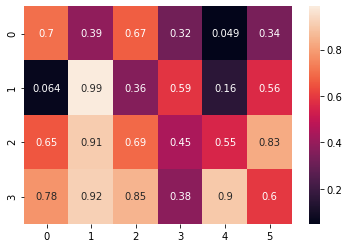

In [25]:
df3 = np.random.rand(4, 6)
heat_map = sns.heatmap(df3, annot=True)

In [ ]:
 #numpy.ndarray
dataset = df.diff_2.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20
100/100 [==============================] - 3s 9ms/step - loss: 0.1264 - val_loss: 0.0134
Epoch 2/20
100/100 [==============================] - 0s 4ms/step - loss: 0.0136 - val_loss: 0.0104
Epoch 3/20
100/100 [==============================] - 0s 4ms/step - loss: 0.0107 - val_loss: 0.0075
Epoch 4/20
100/100 [==============================] - 0s 4ms/step - loss: 0.0077 - val_loss: 0.0052
Epoch 5/20
100/100 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0048
Epoch 6/20
100/100 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 7/20
100/100 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 8/20
100/100 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 9/20
100/100 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 10/20
100/100 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0042

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


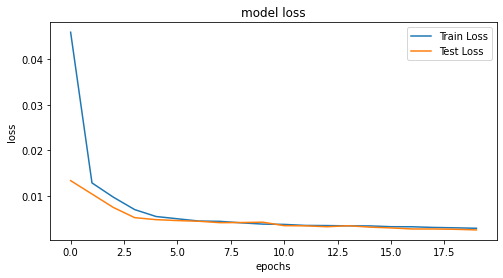

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
import seaborn as sns

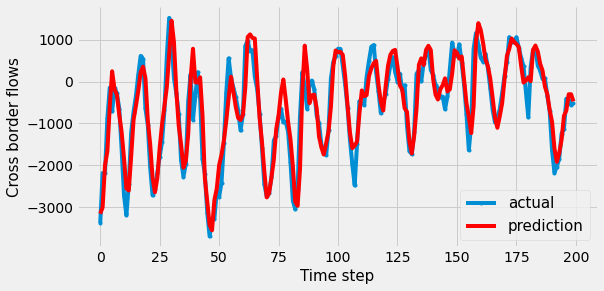

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Cross border flows', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();